In [ ]:
import kagglehub

path = kagglehub.dataset_download("carlolepelaars/camvid")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/carlolepelaars/camvid/versions/2


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score
import random

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        image_dir = os.path.join(root_dir, split)
        mask_dir = os.path.join(root_dir, f'{split}_labels')

        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('_L.png')])

        class_dict_path = os.path.join(root_dir, 'class_dict.csv')
        self.class_df = pd.read_csv(class_dict_path)
        self.name_to_rgb = {row['name']: (row['r'], row['g'], row['b']) for index, row in self.class_df.iterrows()}
        self.rgb_to_id = {v: index for index, v in enumerate(self.name_to_rgb.values())}
        self.id_to_class = {v: k for k, v in enumerate(self.name_to_rgb.keys())}
        self.class_to_id = {k: v for v, k in self.id_to_class.items()}
        self.num_classes = len(self.class_to_id)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = img_name.replace('.png', '_L.png')

        img_path = os.path.join(self.root_dir, self.split, img_name)
        mask_path = os.path.join(self.root_dir, f'{self.split}_labels', mask_name)

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask_np = np.array(mask).astype(np.uint8)
        mask_np = mask_np.transpose(1, 2, 0)

        semantic_mask = np.zeros(mask_np.shape[:2], dtype=np.int64)

        for rgb_tuple, class_id in self.rgb_to_id.items():
            rgb_array = np.array(rgb_tuple, dtype=np.uint8)
            try:
                semantic_mask[(mask_np == rgb_array).all(axis=2)] = class_id
            except ValueError as e:
                raise e

        mask = torch.from_numpy(semantic_mask)

        return image, mask

In [ ]:
img_size = 256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
root_dir = '/root/.cache/kagglehub/datasets/carlolepelaars/camvid/versions/2/CamVid'
train_dataset = CamVidDataset(root_dir, split='train', transform=transform)
val_dataset = CamVidDataset(root_dir, split='val', transform=transform)
test_dataset = CamVidDataset(root_dir, split='test', transform=transform)

In [ ]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class SegNetEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x, indices = self.pool(x)
        return x, indices

In [ ]:
class SegNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, indices, output_size):
        x = self.unpool(x, indices, output_size=output_size)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.encoder1 = SegNetEncoder(in_channels, 64)
        self.encoder2 = SegNetEncoder(64, 128)
        self.encoder3 = SegNetEncoder(128, 256)
        self.encoder4 = SegNetEncoder(256, 512)

        self.decoder4 = SegNetDecoder(512, 256)
        self.decoder3 = SegNetDecoder(256, 128)
        self.decoder2 = SegNetDecoder(128, 64)
        self.decoder1 = SegNetDecoder(64, num_classes)

    def forward(self, x):
        enc1, indices1 = self.encoder1(x)
        enc2, indices2 = self.encoder2(enc1)
        enc3, indices3 = self.encoder3(enc2)
        enc4, indices4 = self.encoder4(enc3)

        dec4 = self.decoder4(enc4, indices4, enc3.size())
        dec3 = self.decoder3(dec4, indices3, enc2.size())
        dec2 = self.decoder2(dec3, indices2, enc1.size())
        dec1 = self.decoder1(dec2, indices1, x.size())

        return dec1


# 평가 함수

In [ ]:
def calculate_f1_metrics(pred_mask, true_mask, threshold=0.5):
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.detach().cpu().numpy()
    if isinstance(true_mask, torch.Tensor):
        true_mask = true_mask.detach().cpu().numpy()

    pred_flat = (pred_mask > threshold).astype(int).flatten()
    true_flat = (true_mask > threshold).astype(int).flatten()

    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)
    f1 = f1_score(true_flat, pred_flat, zero_division=0)

    return precision, recall, f1

In [ ]:
def calculate_pixel_accuracy(pred_mask, true_mask):
    correct_pixels = (pred_mask == true_mask).sum().float()
    total_pixels = torch.numel(pred_mask)
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy


#시각화

In [ ]:
def visualize_segmentation(images, true_masks, pred_masks, id_to_class):
    batch_size = images.size(0)
    fig, axes = plt.subplots(batch_size, 3, figsize=(10, 5 * batch_size))
    for i in range(batch_size):
        img = images[i].permute(1, 2, 0).numpy()
        true_mask = true_masks[i].numpy()
        pred_mask = pred_masks[i].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(decode_segmap(true_mask, id_to_class))
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(decode_segmap(pred_mask, id_to_class))
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

def decode_segmap(mask, id_to_class):
    n_classes = len(id_to_class)
    label_colors = np.random.randint(0, 255, size=(n_classes, 3), dtype=np.uint8)
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
in_channels = 3
num_classes = train_dataset.num_classes
segnet_model = SegNet(in_channels, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(segnet_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 101

#체크포인트 로드

In [ ]:
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"✅ Loaded checkpoint from epoch {start_epoch}")
        return start_epoch
    else:
        print("⚠️ Checkpoint not found. Starting from scratch.")
        return 0

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Dataset/SegNet_CheckPoint'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Dataset/SegNet_CheckPoint/checkpoint_epoch_100.pth'
start_epoch = load_checkpoint(segnet_model, optimizer, checkpoint_path)

✅ Loaded checkpoint from epoch 100


Epoch 101/101 (Train):   0%|          | 0/47 [00:00<?, ?it/s]

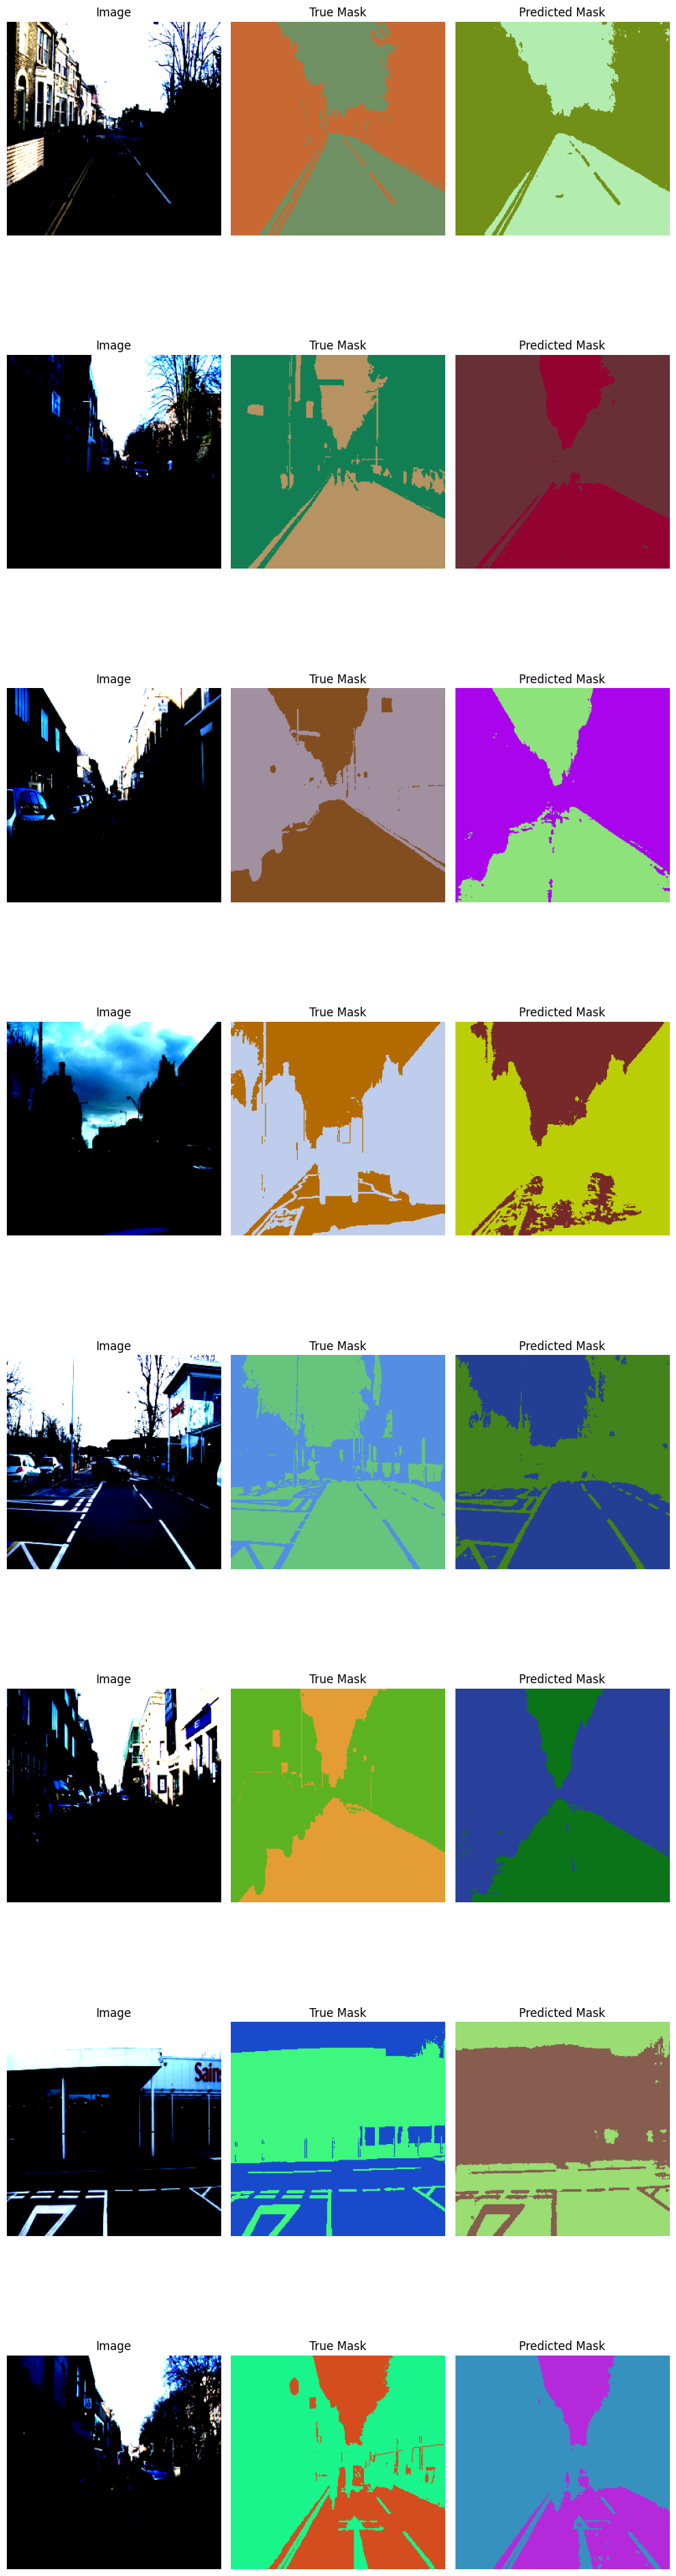

Epoch 101/101 (Validation):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [101/101], Train Loss: 0.2303, Train Pixel Accuracy: 0.9401, Validation Loss: 0.2285, Validation Pixel Accuracy: 0.9432


In [ ]:
train_losses = []
val_losses = []
train_pixel_accuracies = []
val_pixel_accuracies = []

for epoch in range(start_epoch, num_epochs):
    segnet_model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)')
    first_train_batch = True

    for images, masks in train_progress:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = segnet_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_progress.set_postfix(loss=loss.item())

        _, predicted_train = torch.max(outputs.data, 1)
        pixel_accuracy = calculate_pixel_accuracy(predicted_train, masks)
        train_accuracy += pixel_accuracy.item()

        if first_train_batch:
            visualize_segmentation(images.cpu(), masks.cpu(), predicted_train.cpu(), train_dataset.id_to_class)
            first_train_batch = False

    avg_train_loss = train_loss / len(train_loader)
    avg_train_accuracy = train_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_pixel_accuracies.append(avg_train_accuracy)

    segnet_model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)')
    first_val_batch = True

    with torch.no_grad():
        for images_val, masks_val in val_progress:
            images_val = images_val.to(device)
            masks_val = masks_val.to(device)
            outputs_val = segnet_model(images_val)
            loss_val = criterion(outputs_val, masks_val)
            val_loss += loss_val.item()

            _, predicted_val = torch.max(outputs_val.data, 1)
            pixel_accuracy = calculate_pixel_accuracy(predicted_val, masks_val)
            val_accuracy += pixel_accuracy.item()

            val_progress.set_postfix(loss=loss_val.item())

            if first_val_batch:
                first_val_batch = False

    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    val_losses.append(avg_val_loss)
    val_pixel_accuracies.append(avg_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Pixel Accuracy: {train_pixel_accuracies[-1]:.4f}, '
          f'Validation Loss: {val_losses[-1]:.4f}, Validation Pixel Accuracy: {val_pixel_accuracies[-1]:.4f}')

    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': segnet_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
        }, checkpoint_path)
        print(f'Saved checkpoint: {checkpoint_path}')

# 평가

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Dataset/SegNet_CheckPoint/checkpoint_epoch_100.pth'

checkpoint = torch.load(checkpoint_path)

In [ ]:
segnet_model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

print(f"Checkpoint loaded. Starting from epoch {start_epoch}.")
print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Checkpoint loaded. Starting from epoch 100.
Train Loss: 0.2630, Validation Loss: 0.2917


In [ ]:
segnet_model.eval()
segnet_model.to(device)

SegNet(
  (encoder1): SegNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): SegNetEncoder(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_si

In [ ]:
def show_segmentation_result(image, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.cpu().numpy(), cmap='gray')
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.cpu().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    plt.show()

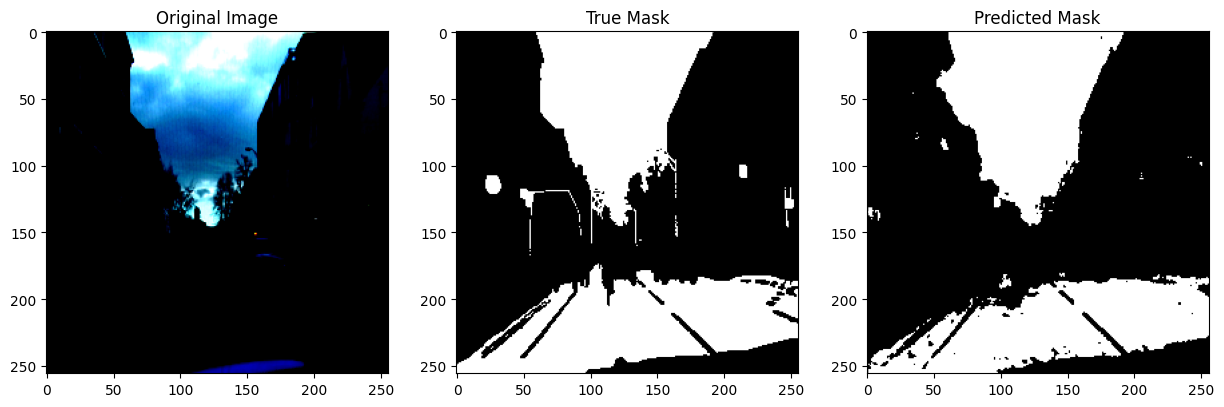

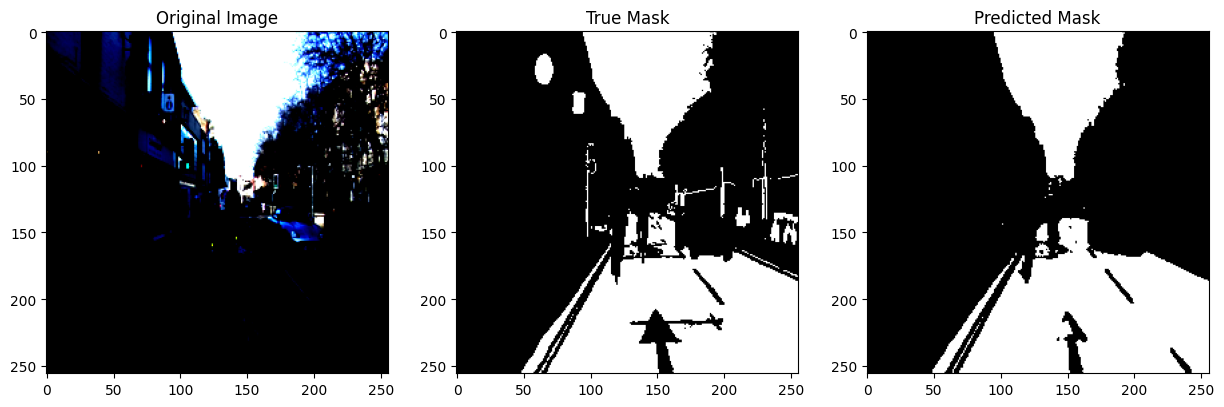

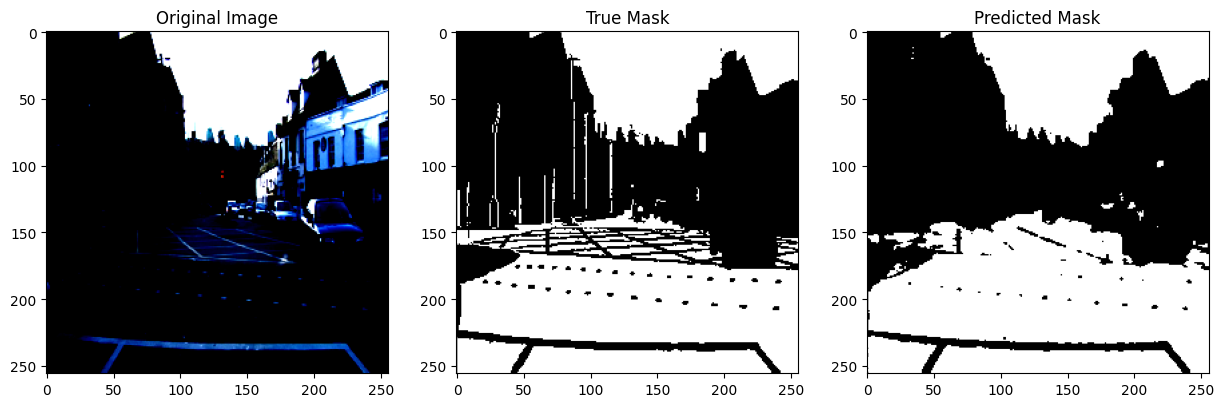

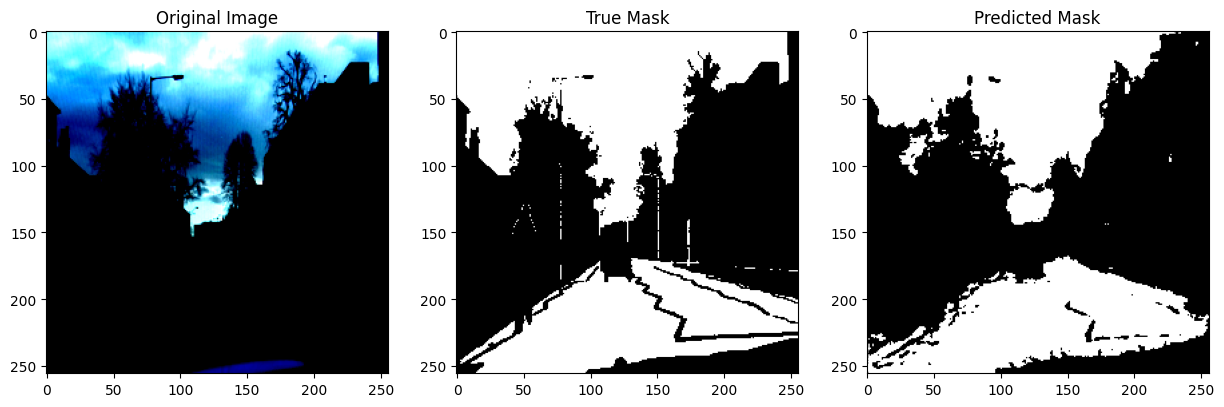

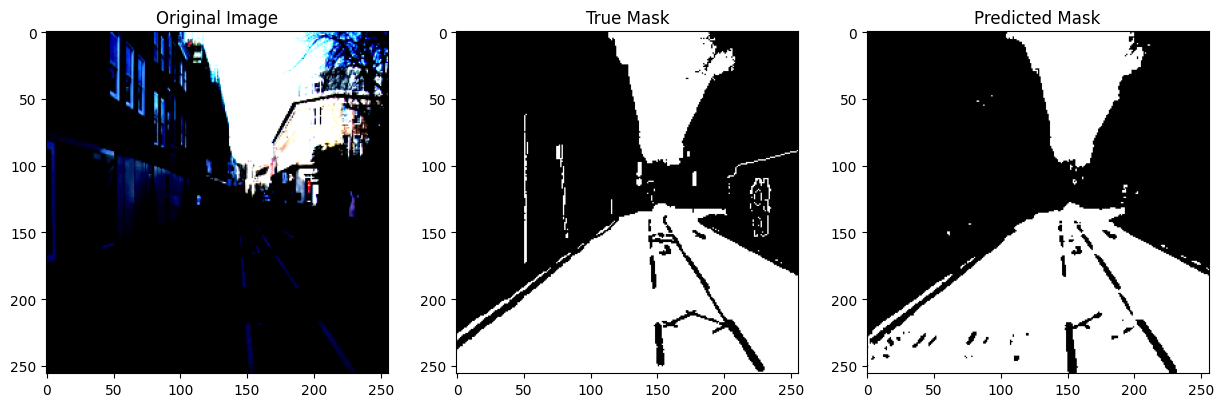

Test Precision: 0.9442
Test Recall: 0.9227
Test F1 Score: 0.9331


In [ ]:
f1_scores = []
precisions = []
recalls = []

test_data = list(test_loader)
random_samples = random.sample(test_data, 5)

with torch.no_grad():
    for i, (image, label) in enumerate(random_samples):
        image, label = image.to(device), label.to(device)

        outputs = segnet_model(image)
        _, predicted = torch.max(outputs.data, 1)

        precision, recall, f1 = calculate_f1_metrics(predicted[0], label[0])
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        show_segmentation_result(image[0], label[0], predicted[0])

print(f"Test Precision: {np.mean(precisions):.4f}")
print(f"Test Recall: {np.mean(recalls):.4f}")
print(f"Test F1 Score: {np.mean(f1_scores):.4f}")